## M4-Competition Benchmark Loop

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from utils.m4 import *

---
## Load Data

In [2]:
df_info = pd.read_csv('./M4-methods/Dataset/M4-info.csv')
data_dict = {}
forecast_horizon = {
    'Hourly':48,
    'Daily':14,
    'Weekly':13,
    'Monthly':18,
    'Quarterly':8,
    'Yearly':6,
}
frequency = {
    'Hourly':24,
    'Daily':1,
    'Weekly':1,
    'Monthly':12,
    'Quarterly':4,
    'Yearly':1,
}

USED_PERIODS = ['Weekly'] #['Hourly','Daily','Weekly','Monthly','Quarterly','Yearly']

for SP in USED_PERIODS:
    data_dict[SP] = {
        'train':pd.read_csv(f'M4-methods/Dataset/Train/{SP}-train.csv'),
        'test': pd.read_csv(f'M4-methods/Dataset/Test/{SP}-test.csv')
    }
df_info = df_info[df_info['SP'].isin(USED_PERIODS)]

---
## Bench Loop

## Benchmark Loop (Single Serie Training)

In [3]:
from models.transformer import TimeSeriesTransformer
from utils.ml import make_batches
from utils.plot import print_losses, generate_square_subsequent_mask

In [4]:
import torch
from torch import nn
def train(model, enc_x, dec_x, tgt_y, epochs=100, lr=0.005, gamma=0.95):
    memory_mask, tgt_mask = model.get_train_masks()
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1, gamma=gamma)
    criterion = nn.MSELoss()
    #
    memory_mask, tgt_mask, model = memory_mask.to('cuda'), tgt_mask.to('cuda'), model.to('cuda') 
    enc_x, dec_x,  tgt_y  = enc_x.to('cuda'), dec_x.to('cuda'), tgt_y.to('cuda')
    #
    data_len = enc_x.shape[0]
    batch_size = 512
    losses = []
    for epoch_i in range(epochs): 
        epoch_losses = []
        for i in range(0, data_len, batch_size):
            batch_enc_x, batch_enc_y, batch_tgt_y = enc_x[i:i+batch_size], dec_x[i:i+batch_size],  tgt_y[i:i+batch_size]
            # zero the parameter gradients
            optimizer.zero_grad()
            pred_y = model(batch_enc_x, batch_enc_y, None, tgt_mask)
            
            # Compute and backprop loss
            loss = criterion(batch_tgt_y, pred_y)
            loss.backward()
            epoch_losses.append(loss.detach().cpu())
            optimizer.step() #  Take optimizer step
        scheduler.step()
        
        losses.append(np.mean(epoch_losses))
    #     print(f'Epoch {epoch_i+1} loss: {np.mean(epoch_losses)} | lr =',optimizer.param_groups[0]['lr'])
    # print_losses(losses, offset=0)

def infer(model, src, forecast_horizon):
    with torch.no_grad():
        output = torch.zeros(1, forecast_horizon + 1, 1)
        output[0, 0, 0] = src[0, -1]
        for i in range(forecast_horizon):
            dim_a = output.shape[1]
            tgt_mask = generate_square_subsequent_mask(dim_a, dim_a).to('cuda')
            y = model(src, output, None, tgt_mask)[0,i,0]
            output[0,i+1,0] = y

    return output.flatten()[1:]


In [5]:
fh = 13
freq = 1
in_size = 7*3  # number of points used as input for each forecast
INPUT_LEN = in_size
FORECAST_HORIZON = fh
model_params = {
        'in_features':1, # The number of input variables. 1 if univariate forecasting.
        'input_len':INPUT_LEN,
        'max_input_len':7*4, # What's the longest sequence the model will encounter? Used to make the positional encoder
        'forecast_horizon':FORECAST_HORIZON, # Length of the target sequence, i.e. how many time steps should your forecast cover
        'd_model':8, # model embedding dimension This can be any value divisible by n_heads. 512 is used in the original transformer paper.
        'encoder_nheads':4, # The number of attention heads (parallel attention layers)
        'encoder_nlayers':2, # Number of times the layer is stacked
        'encoder_dropout': 0,#0.1,
        'encoder_ps_dropout': 0,#0.1,
        'feedforward_dim':8,
        'decoder_nheads':4, # The number of attention heads (parallel attention layers)
        'decoder_nlayers':2, # Number of times the layer is stacked
        'decoder_dropout': 0,#0.1, # with zeroed dropout we can reproduce the outputs.
        'seed':7,
        'mapping_dim':16
    }
total_params = sum(p.numel() for p in TimeSeriesTransformer(model_params).parameters())
print(f"Number of parameters: {total_params}")

Number of parameters: 2505


In [33]:
dec_x.shape

torch.Size([2146, 13, 1])

In [19]:
dec_x

tensor([[[0.5893],
         [0.5890],
         [0.5884],
         ...,
         [0.5849],
         [0.5844],
         [0.5844]],

        [[0.5890],
         [0.5884],
         [0.5884],
         ...,
         [0.5844],
         [0.5844],
         [0.5836]],

        [[0.5884],
         [0.5884],
         [0.5879],
         ...,
         [0.5844],
         [0.5836],
         [0.5831]],

        ...,

        [[0.8722],
         [0.8202],
         [0.8197],
         ...,
         [0.8497],
         [0.8600],
         [0.8595]],

        [[0.8202],
         [0.8197],
         [0.8426],
         ...,
         [0.8600],
         [0.8595],
         [0.7927]],

        [[0.8197],
         [0.8426],
         [0.8421],
         ...,
         [0.8595],
         [0.7927],
         [0.7922]]])

In [6]:
ERRORS = {
    'naive_1':{p:{'sMAPE':[],'MASE':[]} for p in USED_PERIODS},
    'mlp':{p:{'sMAPE':[],'MASE':[]} for p in USED_PERIODS},
    'transformer':{p:{'sMAPE':[],'MASE':[]} for p in USED_PERIODS}
    }

for serie_index in [0]:#tqdm(range(len(df_info))):
    serie_info = df_info.iloc[serie_index]
    serie_id = serie_info.M4id
    serie_sp = serie_info.SP
    fh = forecast_horizon[serie_sp]
    freq = frequency[serie_sp]
    in_size = 7*3  # number of points used as input for each forecast
    INPUT_LEN = in_size
    FORECAST_HORIZON = fh
    model_params = {
        'in_features':1, # The number of input variables. 1 if univariate forecasting.
        'input_len':INPUT_LEN,
        'max_input_len':7*4, # What's the longest sequence the model will encounter? Used to make the positional encoder
        'forecast_horizon':FORECAST_HORIZON, # Length of the target sequence, i.e. how many time steps should your forecast cover
        'd_model':8, # model embedding dimension This can be any value divisible by n_heads. 512 is used in the original transformer paper.
        'encoder_nheads':4, # The number of attention heads (parallel attention layers)
        'encoder_nlayers':2, # Number of times the layer is stacked
        'encoder_dropout': 0,#0.1,
        'encoder_ps_dropout': 0,#0.1,
        'feedforward_dim':8,
        'decoder_nheads':4, # The number of attention heads (parallel attention layers)
        'decoder_nlayers':2, # Number of times the layer is stacked
        'decoder_dropout': 0,#0.1, # with zeroed dropout we can reproduce the outputs.
        'seed':7,
        'mapping_dim':16
    }
    #
    train_df = data_dict[serie_sp]['train']
    test_df = data_dict[serie_sp]['test']
    # filtra a serie, remove os valores nan e remove o id da serie(presente no 1 valor)
    train_serie = train_df[train_df.V1 == serie_id].dropna(axis=1).values.reshape(-1)[1:]
    test_serie = test_df[test_df.V1 == serie_id].dropna(axis=1).values.reshape(-1)[1:]
    test_serie = test_serie[:fh] # forecast only fh steps
    train_serie = np.asarray(train_serie, dtype=np.float32)
    test_serie = np.asarray(test_serie, dtype=np.float32)
    ts = np.concatenate([train_serie, test_serie], dtype=np.float32)
    #
    # Remove sazonality and trend
    #
    # remove seasonality
    seasonality_in = deseasonalize(ts, freq)

    for i in range(0, len(ts)):
        ts[i] = ts[i] * 100 / seasonality_in[i % freq]

    # detrending
    a, b = detrend(ts)
    for i in range(0, len(ts)):
        ts[i] = ts[i] - ((a * i) + b)
    #
    # SCALE
    #
    scale = True
    if scale:
        scaler = MinMaxScaler()
        scaler.fit(ts[:-fh].reshape(-1, 1))
        ts = scaler.transform(ts.reshape(-1, 1)).flatten()
    #
    # Transformer Input
    #
    enc_x, dec_x, tgt_y = make_batches(ts[:-fh], INPUT_LEN, FORECAST_HORIZON)
    model = TimeSeriesTransformer(model_params)
    # train(model, enc_x, dec_x, tgt_y, 100, lr=0.005, gamma=1.01)
    train(model, enc_x, dec_x, tgt_y, 100, lr=0.005, gamma=0.95)
    #
    # Transformer Inference
    #
    last_train_values = ts[:-fh] # remove test
    last_train_values =  torch.tensor( 
        np.asarray(last_train_values[-INPUT_LEN:]).reshape(1, INPUT_LEN, 1), dtype=torch.float32)
    # model.eval()
    model = model.to('cpu')
    transformer_pred_y = infer(model, last_train_values, forecast_horizon=fh).detach()
    #
    # Inverse scale
    #
    if scale:
        ts = scaler.inverse_transform(ts.reshape(-1, 1)).flatten()
        transformer_pred_y = scaler.inverse_transform(transformer_pred_y.reshape(-1, 1)).flatten()
    #
    # Add sazonality and trend
    #
    for i in range(0, len(ts)):
        ts[i] = ts[i] + ((a * i) + b)

    for i in range(0, fh):
        transformer_pred_y[i] = transformer_pred_y[i] + ((a * (len(ts) + i + 1)) + b)

    # add seasonality
    for i in range(0, len(ts)):
        ts[i] = ts[i] * seasonality_in[i % freq] / 100

    for i in range(len(ts), len(ts) + fh):
        transformer_pred_y[i - len(ts)] = transformer_pred_y[i - len(ts)] * seasonality_in[i % freq] / 100

    # check if negative or extreme
    for i in range(len(transformer_pred_y)):
        if transformer_pred_y[i] < 0:
            transformer_pred_y[i] = 0
            
        if transformer_pred_y[i] > (1000 * max(ts)):
            transformer_pred_y[i] = max(ts)   
    # transformer_pred_y = transformer_pred_y.numpy()
    # Vanila TF
    ERRORS['transformer'][serie_sp]['sMAPE'].append(smape(test_serie, transformer_pred_y))
    ERRORS['transformer'][serie_sp]['MASE'].append(mase(ts[:-fh], test_serie, transformer_pred_y, freq))  

print("---------FINAL RESULTS---------")
for model, err in ERRORS.items():
    print(f'Model : {model}')
    for sp, sp_err in err.items():
        print(f'  {sp}: ')
        print(f'    sMAPE: {np.mean(sp_err["sMAPE"])*100:.3f}')
        print(f'    MASE: {np.mean(sp_err["MASE"]):.3f}')
  

---------FINAL RESULTS---------
Model : naive_1
  Weekly: 
    sMAPE: nan
    MASE: nan
Model : mlp
  Weekly: 
    sMAPE: nan
    MASE: nan
Model : transformer
  Weekly: 
    sMAPE: 10.421
    MASE: 61.561


In [8]:
test_serie

array([35397.16, 35808.59, 35808.59, 36246.14, 36246.14, 36403.7 ,
       36403.7 , 36150.2 , 36150.2 , 35790.55, 35790.55, 34066.95,
       34066.95], dtype=float32)

In [16]:
transformer_pred_y

array([38451.51628358, 39153.91954162, 39418.24694772, 39562.54709974,
       39658.57094102, 39729.88358449, 39786.61548188, 39833.94077062,
       39874.51689305, 39910.22718157, 39942.50926894, 39972.14731846,
       39999.71102143])

In [17]:
y_test

array([35397.16, 35808.59, 35808.59, 36246.14, 36246.14, 36403.7 ,
       36403.7 , 36150.2 , 36150.2 , 35790.55, 35790.55, 34066.95,
       34066.95], dtype=float32)

## Experimentos

In [7]:
Model : transformer (full data)
  Weekly: 
    sMAPE: 20.103
    MASE: 10.419

SyntaxError: invalid syntax. Perhaps you forgot a comma? (2939050784.py, line 1)

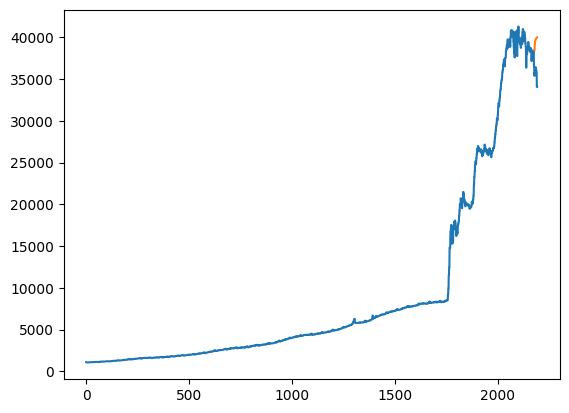

In [13]:
plt.plot(range(0,len(ts)), ts)
plt.plot(range(len(ts)-fh,len(ts)), transformer_pred_y)

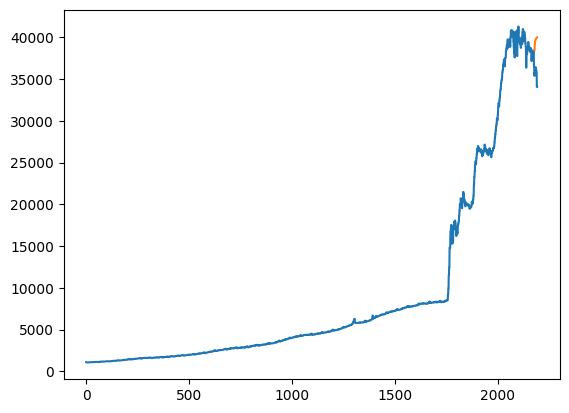

In [ ]:
    # #
    # # output = output[0,1:,0] # remove the SOS token
    # output = output.detach().numpy().flatten()
    # time = np.arange(0, input_steps + forecast_horizon)
    # plt.figure(figsize=(18,5))
    # plt.plot(time[:input_steps], src.numpy().flatten(), 'g', label='Encoder Input')
    # plt.plot(time[input_steps:input_steps+tgt_steps], tgt_y.numpy().flatten(), 'y', label='Reality')
    # plt.plot(time[input_steps-1:], output, 'r', label='Prediction') # o 1 valor de output é o ultimo tipestamp do input
    # plt.legend()
    # plt.show()

## Benchmarks

In [9]:
ERRORS = {
    'naive_1':{p:{'sMAPE':[],'MASE':[]} for p in USED_PERIODS},
    'mlp':{p:{'sMAPE':[],'MASE':[]} for p in USED_PERIODS}
    }

for serie_index in [0]:#tqdm(range(len(df_info))):
    serie_info = df_info.iloc[serie_index]
    serie_id = serie_info.M4id
    serie_sp = serie_info.SP
    fh = forecast_horizon[serie_sp]
    freq = frequency[serie_sp]
    in_size = 3  # number of points used as input for each forecast
    #
    train_df = data_dict[serie_sp]['train']
    test_df = data_dict[serie_sp]['test']
    # filtra a serie, remove os valores nan e remove o id da serie(presente no 1 valor)
    train_serie = train_df[train_df.V1 == serie_id].dropna(axis=1).values.reshape(-1)[1:]
    test_serie = test_df[test_df.V1 == serie_id].dropna(axis=1).values.reshape(-1)[1:]
    test_serie = test_serie[:fh] # forecast only fh steps
    train_serie = np.asarray(train_serie, dtype=np.float32)
    test_serie = np.asarray(test_serie, dtype=np.float32)
    ts = np.concatenate([train_serie, test_serie], dtype=np.float32)
    #
    #
    #
    # remove seasonality
    seasonality_in = deseasonalize(ts, freq)

    for i in range(0, len(ts)):
        ts[i] = ts[i] * 100 / seasonality_in[i % freq]

    # detrending
    a, b = detrend(ts)

    for i in range(0, len(ts)):
        ts[i] = ts[i] - ((a * i) + b)
    # scaler = MinMaxScaler()
    # scaler.fit(ts[:-fh].reshape(-1, 1))
    # ts = scaler.transform(ts.reshape(-1, 1)).flatten()
    x_train, y_train, x_test, y_test = split_into_train_test(ts, in_size, fh)
    # MLP benchmark - Produce forecasts
    # y_hat_test_MLP = mlp_bench(x_train.copy(), y_train.copy(), x_test.copy(), fh)

    # ts = scaler.inverse_transform(ts.reshape(-1, 1)).flatten()
    # y_hat_test_MLP = scaler.inverse_transform(y_hat_test_MLP.reshape(-1, 1)).flatten()
    # y_test = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
    # MLP benchmark - Produce forecasts
    y_hat_test_MLP = mlp_bench(x_train, y_train, x_test, fh)
    for i in range(0, 29):
        y_hat_test_MLP = np.vstack((y_hat_test_MLP, mlp_bench(x_train, y_train, x_test, fh)))
    y_hat_test_MLP = np.median(y_hat_test_MLP, axis=0)

    # add trend
    for i in range(0, len(ts)):
        ts[i] = ts[i] + ((a * i) + b)

    for i in range(0, fh):
        y_hat_test_MLP[i] = y_hat_test_MLP[i] + ((a * (len(ts) + i + 1)) + b)

    # add seasonality
    for i in range(0, len(ts)):
        ts[i] = ts[i] * seasonality_in[i % freq] / 100

    for i in range(len(ts), len(ts) + fh):
        y_hat_test_MLP[i - len(ts)] = y_hat_test_MLP[i - len(ts)] * seasonality_in[i % freq] / 100

    # check if negative or extreme
    for i in range(len(y_hat_test_MLP)):
        if y_hat_test_MLP[i] < 0:
            y_hat_test_MLP[i] = 0
            
        if y_hat_test_MLP[i] > (1000 * max(ts)):
            y_hat_test_MLP[i] = max(ts)   

    x_train, y_train, x_test, y_test = split_into_train_test(ts, in_size, fh)

    
    # Create Train examples for MLP and RNN
   
    # train_x, train_y, test_x, test_y = split_into_train_test(train_serie, test_serie, in_size)
    
    #Naive Forecast (Benchmark)
    
    # pred_y =  naive_predict(train_serie, test_serie, fh)
    # ERRORS['naive_1'][serie_sp]['sMAPE'].append(smape(test_serie, pred_y))
    # ERRORS['naive_1'][serie_sp]['MASE'].append(mase(train_serie, test_serie, pred_y, freq))
    
    # MLP (Benchmark)
    #
    ERRORS['mlp'][serie_sp]['sMAPE'].append(smape(y_test, y_hat_test_MLP))
    ERRORS['mlp'][serie_sp]['MASE'].append(mase(ts[:-fh], y_test, y_hat_test_MLP, freq))  
  



In [10]:
y_test

array([35397.16, 35808.59, 35808.59, 36246.14, 36246.14, 36403.7 ,
       36403.7 , 36150.2 , 36150.2 , 35790.55, 35790.55, 34066.95,
       34066.95], dtype=float32)

In [11]:
print("---------FINAL RESULTS---------")
for model, err in ERRORS.items():
    print(f'Model : {model}')
    for sp, sp_err in err.items():
        print(f'  {sp}: ')
        print(f'    sMAPE: {np.mean(sp_err["sMAPE"])*100:.3f}')
        print(f'    MASE: {np.mean(sp_err["MASE"]):.3f}')

---------FINAL RESULTS---------
Model : naive_1
  Weekly: 
    sMAPE: nan
    MASE: nan
Model : mlp
  Weekly: 
    sMAPE: 4.041
    MASE: 23.000


## Benchmark Loop (Multiple Serie Training)

In [ ]:
ERRORS = {
    'naive_1':{p:{'sMAPE':[],'MASE':[]} for p in USED_PERIODS},
    'mlp':{p:{'sMAPE':[],'MASE':[]} for p in USED_PERIODS}
    }


In [ ]:
# !pip3 install -r requirements.txt

In [ ]:
ERRORS = {
    'naive_1':{p:{'sMAPE':[],'MASE':[]} for p in USED_PERIODS},
    'mlp':{p:{'sMAPE':[],'MASE':[]} for p in USED_PERIODS}
    }

for serie_index in tqdm(range(len(df_info))):
    serie_info = df_info.iloc[serie_index]
    serie_id = serie_info.M4id
    serie_sp = serie_info.SP
    fh = forecast_horizon[serie_sp]
    freq = frequency[serie_sp]
    in_size = 3  # number of points used as input for each forecast
    #
    train_df = data_dict[serie_sp]['train']
    test_df = data_dict[serie_sp]['test']
    # filtra a serie, remove os valores nan e remove o id da serie(presente no 1 valor)
    train_serie = train_df[train_df.V1 == serie_id].dropna(axis=1).values.reshape(-1)[1:]
    test_serie = test_df[test_df.V1 == serie_id].dropna(axis=1).values.reshape(-1)[1:]
    test_serie = test_serie[:fh] # forecast only fh steps
    train_serie = np.asarray(train_serie, dtype=np.float32)
    test_serie = np.asarray(test_serie, dtype=np.float32)
    ts = np.concatenate([train_serie, test_serie], dtype=np.float32)
    #
    #
    #
    # remove seasonality
    seasonality_in = deseasonalize(ts, freq)

    for i in range(0, len(ts)):
        ts[i] = ts[i] * 100 / seasonality_in[i % freq]

    # detrending
    a, b = detrend(ts)

    for i in range(0, len(ts)):
        ts[i] = ts[i] - ((a * i) + b)
    # scaler = MinMaxScaler()
    # scaler.fit(ts[:-fh].reshape(-1, 1))
    # ts = scaler.transform(ts.reshape(-1, 1)).flatten()
    x_train, y_train, x_test, y_test = split_into_train_test(ts, in_size, fh)
    # MLP benchmark - Produce forecasts
    # y_hat_test_MLP = mlp_bench(x_train.copy(), y_train.copy(), x_test.copy(), fh)

    # ts = scaler.inverse_transform(ts.reshape(-1, 1)).flatten()
    # y_hat_test_MLP = scaler.inverse_transform(y_hat_test_MLP.reshape(-1, 1)).flatten()
    # y_test = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
    # MLP benchmark - Produce forecasts
    y_hat_test_MLP = mlp_bench(x_train, y_train, x_test, fh)
    for i in range(0, 29):
        y_hat_test_MLP = np.vstack((y_hat_test_MLP, mlp_bench(x_train, y_train, x_test, fh)))
    y_hat_test_MLP = np.median(y_hat_test_MLP, axis=0)

    # add trend
    for i in range(0, len(ts)):
        ts[i] = ts[i] + ((a * i) + b)

    for i in range(0, fh):
        y_hat_test_MLP[i] = y_hat_test_MLP[i] + ((a * (len(ts) + i + 1)) + b)

    # add seasonality
    for i in range(0, len(ts)):
        ts[i] = ts[i] * seasonality_in[i % freq] / 100

    for i in range(len(ts), len(ts) + fh):
        y_hat_test_MLP[i - len(ts)] = y_hat_test_MLP[i - len(ts)] * seasonality_in[i % freq] / 100

    # check if negative or extreme
    for i in range(len(y_hat_test_MLP)):
        if y_hat_test_MLP[i] < 0:
            y_hat_test_MLP[i] = 0
            
        if y_hat_test_MLP[i] > (1000 * max(ts)):
            y_hat_test_MLP[i] = max(ts)   

    x_train, y_train, x_test, y_test = split_into_train_test(ts, in_size, fh)

    
    # Create Train examples for MLP and RNN
   
    # train_x, train_y, test_x, test_y = split_into_train_test(train_serie, test_serie, in_size)
    
    #Naive Forecast (Benchmark)
    
    # pred_y =  naive_predict(train_serie, test_serie, fh)
    # ERRORS['naive_1'][serie_sp]['sMAPE'].append(smape(test_serie, pred_y))
    # ERRORS['naive_1'][serie_sp]['MASE'].append(mase(train_serie, test_serie, pred_y, freq))
    
    # MLP (Benchmark)
    #
    ERRORS['mlp'][serie_sp]['sMAPE'].append(smape(y_test, y_hat_test_MLP))
    ERRORS['mlp'][serie_sp]['MASE'].append(mase(ts[:-fh], y_test, y_hat_test_MLP, freq))  
  

